# 11 Deployment Feature Vis

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


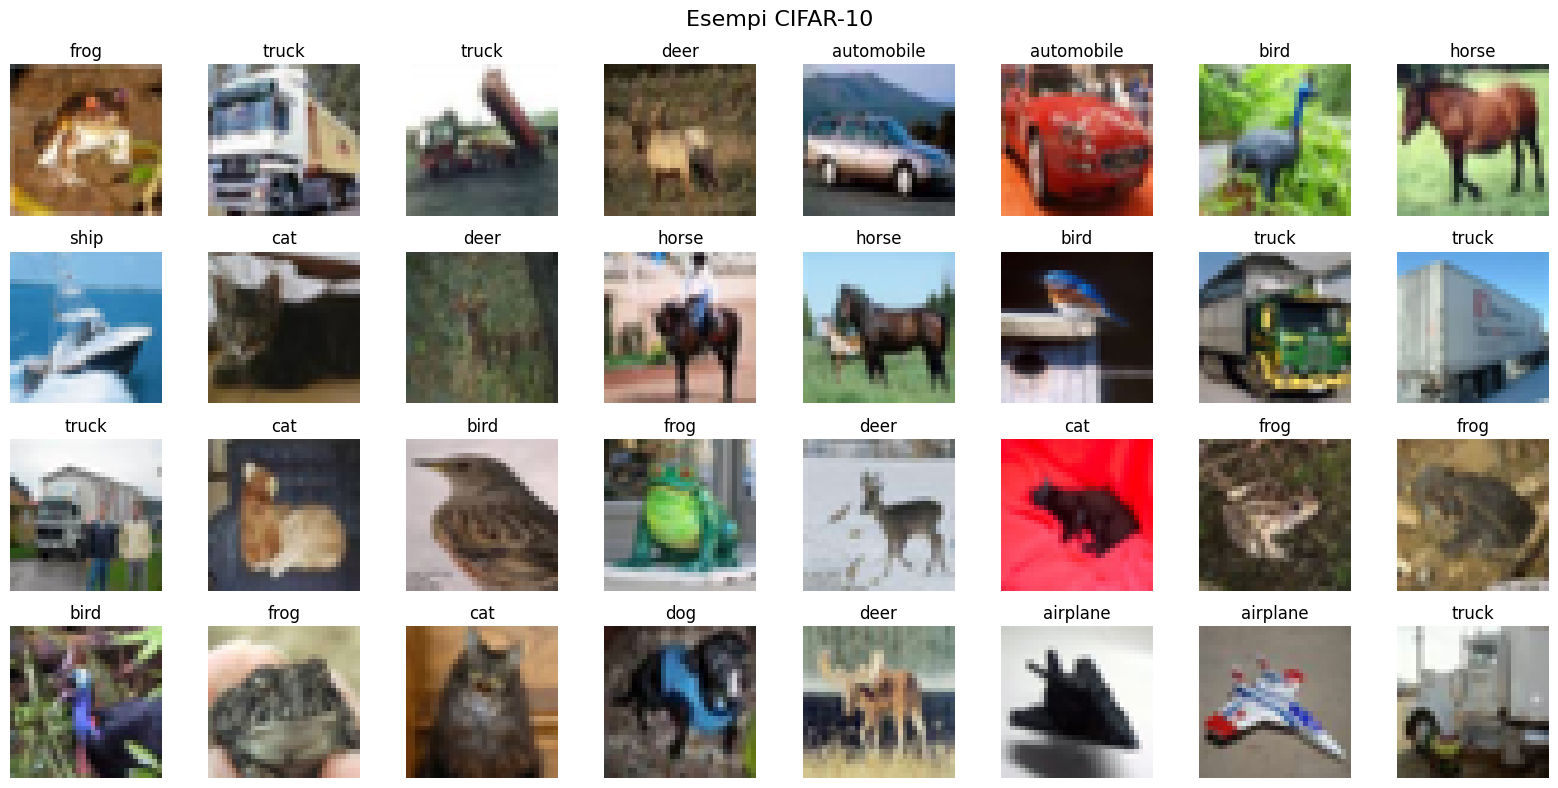

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

In [2]:
# Normalizzazione a [0,1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Converti in tensori PyTorch (NCHW format)
X_train_tensor = torch.from_numpy(X_train_norm).permute(0, 3, 1, 2)  # NHWC -> NCHW
X_test_tensor = torch.from_numpy(X_test_norm).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape dopo preprocessing:")
print(f"  X_train tensor: {X_train_tensor.shape}")
print(f"  y_train tensor: {y_train_tensor.shape}")
print(f"Range valori: [{X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}]")

Shape dopo preprocessing:
  X_train tensor: torch.Size([50000, 3, 32, 32])
  y_train tensor: torch.Size([50000])
Range valori: [0.00, 1.00]


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5,
                lr=0.001, patience=5, patience_lr=3, device=device):
    """
    Training loop generico PyTorch con early stopping e ReduceLROnPlateau.
    Restituisce un dizionario con history (come Keras).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience_lr, min_lr=1e-7
    )

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, device=device):
    """Evaluate model and return loss, accuracy, predictions."""
    model.eval()
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.append(predicted.cpu())
            all_probs.append(probs.cpu())

    test_loss = test_loss / total
    test_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return test_loss, test_acc, all_preds, all_probs

In [ ]:
# VGG16 Transfer Learning
# ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Normalize CIFAR-10 data with ImageNet stats
def normalize_imagenet(X_np):
    """X_np: NHWC float32 [0,255] -> NCHW tensor normalized with ImageNet stats."""
    X = X_np.astype('float32') / 255.0
    X_t = torch.from_numpy(X).permute(0, 3, 1, 2)  # NCHW
    for c in range(3):
        X_t[:, c] = (X_t[:, c] - imagenet_mean[c]) / imagenet_std[c]
    return X_t

---

## 5. Utilizzo di Foundation Models tramite API

Molti servizi cloud offrono API per Computer Vision senza dover trainare modelli.

### 5.1 Simulazione API Google Cloud Vision

In [17]:
import base64
from io import BytesIO
from PIL import Image

class SimulatedVisionAPI:
    """
    Simulazione di una API per Computer Vision.
    In produzione, useresti chiamate HTTP reali:
    - Google Cloud Vision API
    - AWS Rekognition
    - Azure Computer Vision
    """

    def __init__(self, model, device=device):
        self.model = model
        self.device = device
        self.class_names = [
            'airplane', 'automobile', 'bird',
            'cat', 'deer', 'dog', 'frog',
            'horse', 'ship', 'truck'
        ]

    def predict_from_array(self, image_array, top_k=5):
        """Predice da un array numpy (HWC, uint8 o float)."""
        img = image_array.astype('float32')
        if img.max() > 1:
            img = img / 255.0

        # Convert to tensor NCHW
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(img_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

        top_indices = np.argsort(probs)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append({
                'class': self.class_names[idx],
                'confidence': float(probs[idx])
            })

        return {
            'predictions': results,
            'top_class': results[0]['class'],
            'top_confidence': results[0]['confidence']
        }


# Test API simulata
api = SimulatedVisionAPI(model_simple)

# Predizione su alcune immagini di test
print("Test API Computer Vision")
print("=" * 50)

for i in range(5):
    result = api.predict_from_array(X_test[i])
    true_label = class_names[y_test[i]]
    pred_label = result['top_class']
    conf = result['top_confidence']
    status = "OK" if true_label == pred_label else "MISS"
    print(
        f"[{status}] True: {true_label:>12s} | "
        f"Pred: {pred_label:>12s} "
        f"(conf: {conf:.2%})"
    )

Test API Computer Vision
[OK] True:          cat | Pred:          cat (conf: 75.50%)
[OK] True:         ship | Pred:         ship (conf: 97.43%)
[OK] True:         ship | Pred:         ship (conf: 72.78%)
[OK] True:     airplane | Pred:     airplane (conf: 99.87%)
[OK] True:         frog | Pred:         frog (conf: 97.33%)


### 5.2 Esempio: REST API con Flask (struttura)

In produzione, potresti esporre il modello via REST API:

In [18]:
# Questo e' codice illustrativo (non eseguibile)
"""
from flask import Flask, request, jsonify
import numpy as np
import torch
from PIL import Image

app = Flask(__name__)

# Carica modello all'avvio
model = SimpleCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

@app.route('/predict', methods=['POST'])
def predict():
    # Ricevi immagine
    file = request.files['image']
    img = Image.open(file).resize((32, 32))

    # Preprocessing
    img_array = np.array(img).astype('float32') / 255.0
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0)

    # Predizione
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        class_idx = probs.argmax(1).item()

    return jsonify({
        'class': class_names[class_idx],
        'confidence': float(probs[0][class_idx])
    })

if __name__ == '__main__':
    app.run(debug=True)
"""
print("Codice Flask illustrativo (non eseguito)")

Codice Flask illustrativo (non eseguito)


---

## 6. Visualizzazione Feature Maps

Visualizziamo cosa "vede" la CNN a diversi livelli.

Feature extractor creato dal modello trainato (model_simple)!
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048

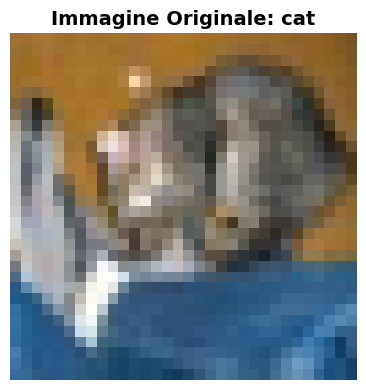

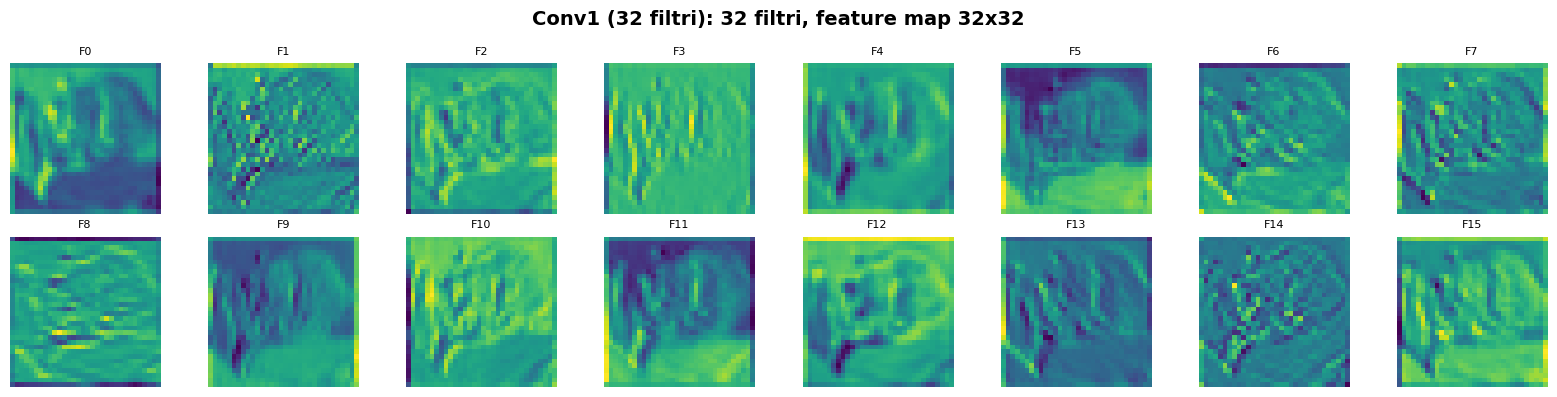

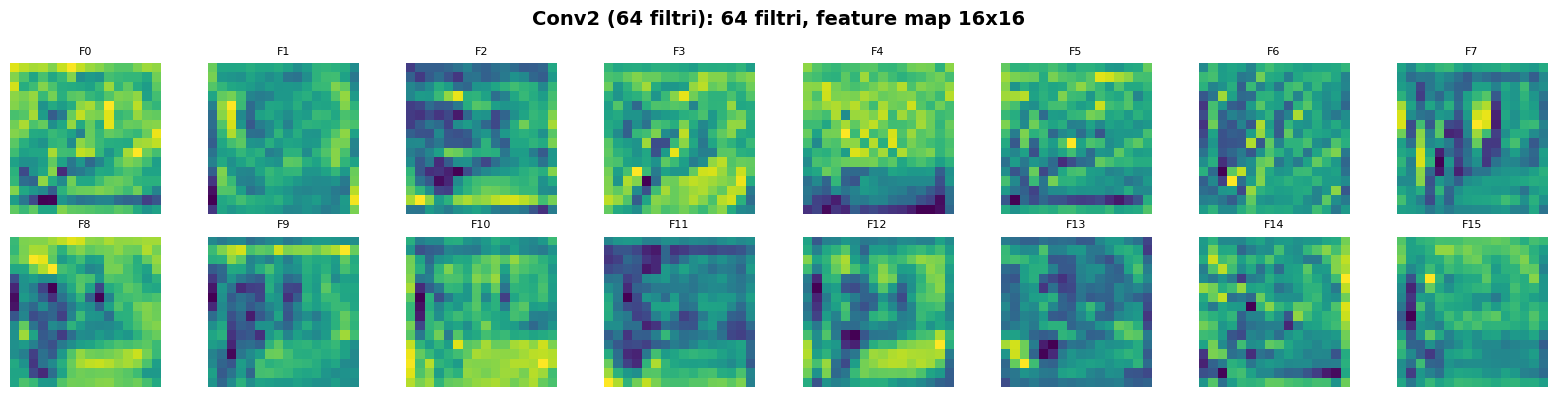

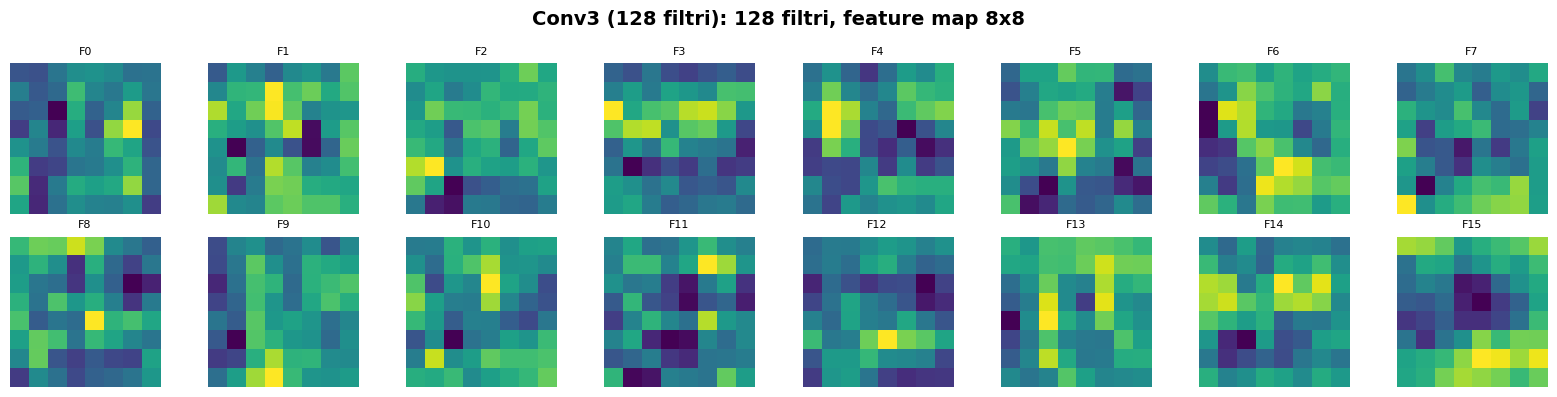

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse the already-trained model_simple for meaningful feature maps
# Use PyTorch hooks to extract feature maps

print("Feature extractor creato dal modello trainato (model_simple)!")
print(model_simple)

# Define which layers to visualize
# model_simple.features has: Conv2d(0), BN(1), ReLU(2), MaxPool(3),
#                            Conv2d(4), BN(5), ReLU(6), MaxPool(7),
#                            Conv2d(8), BN(9), ReLU(10), MaxPool(11)
target_layers = {
    'conv1': model_simple.features[0],
    'conv2': model_simple.features[4],
    'conv3': model_simple.features[8],
}

# Register hooks to capture activations
activations = {}
hooks = []

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

for name, layer in target_layers.items():
    h = layer.register_forward_hook(get_activation(name))
    hooks.append(h)

# Run a forward pass with a test image
test_img = X_test_norm[0]  # HWC float32 [0,1]
test_tensor = torch.from_numpy(test_img).permute(2, 0, 1).unsqueeze(0).float().to(device)

model_simple.eval()
with torch.no_grad():
    _ = model_simple(test_tensor)

# Remove hooks
for h in hooks:
    h.remove()

print(f"Dimensione immagine: {test_img.shape}")

# Visualizza immagine originale
plt.figure(figsize=(4, 4))
plt.imshow(test_img)
plt.title(
    f"Immagine Originale: {class_names[y_test[0]]}",
    fontsize=14, fontweight='bold'
)
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualizza feature maps
layer_display_names = {
    'conv1': 'Conv1 (32 filtri)',
    'conv2': 'Conv2 (64 filtri)',
    'conv3': 'Conv3 (128 filtri)',
}

for layer_key in ['conv1', 'conv2', 'conv3']:
    layer_act = activations[layer_key][0]  # Remove batch dim: [C, H, W]
    n_features = layer_act.shape[0]
    size = layer_act.shape[1]

    n_cols = 8
    n_rows = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4))

    for i, ax in enumerate(axes.flat):
        if i < min(n_features, 16):
            feature_map = layer_act[i].numpy()  # [H, W]
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
            ax.set_title(f'F{i}', fontsize=8)
        else:
            ax.axis('off')

    display_name = layer_display_names[layer_key]
    plt.suptitle(
        f'{display_name}: {n_features} filtri, '
        f'feature map {size}x{size}',
        fontsize=14, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

**Osservazioni** (feature maps dal modello trainato `model_simple`):
- **Layer 1 (conv1)**: rileva bordi, colori base
- **Layer 2 (conv2)**: pattern piu' complessi, combinazioni di bordi
- **Layer 3 (conv3)**: rappresentazioni astratte di alto livello

Le feature maps provengono dal modello gia' addestrato, quindi riflettono pattern effettivamente appresi durante il training.

---